In [4]:
import matrixprofile as mp
from grammar import GrammarInduction
from mkalgo.mk import mk
import numpy as np
import matplotlib.pyplot as plt
from sax import SAX_subsequences
from datetime import datetime
import stumpy


def stomp(ts, windowsize=200, topk=3):
    """
    Extract and visualize Motif in time series using STMOP algorithm
    ts: DataFrame, two columns, one for time and one for variables
    windowsize:Time Window
    topk:The topk motifs to extract and visualize
    """
    starttime = datetime.now()
    ts = ts[ts.columns[1]].values
    profile = mp.algorithms.stomp(ts, windowsize)
    profile = mp.discover.motifs(profile, k=topk)
    mp.visualize(profile)

    endtime = datetime.now()
    print(endtime - starttime)

    return


def scrimp_2plus(ts, windowsize=200, topk=3):
    starttime = datetime.now()
    ts = ts[ts.columns[1]].values
    """
    Extract and visualize Motif in time series using Scrimp++ algorithm
    ts: DataFrame, two columns, one for time and one for variables
    windowsize:Time Window
    topk:The topk motifs to extract and visualize
    """
    profile = mp.algorithms.scrimp.scrimp_plus_plus(ts, windowsize)
    profile = mp.discover.motifs(profile, k=topk)
    mp.visualize(profile)

    endtime = datetime.now()
    print(endtime - starttime)

    return


def stump(ts, windowsize=200, topk=3):
    """
    Extract and visualize Motif in time series using Stump(SCAMP) algorithm
    ts: DataFrame, two columns, one for time and one for variables
    windowsize:Time Window
    topk:The topk motifs to extract and visualize
    """
    starttime = datetime.now()

    m = windowsize
    mp = stumpy.stump(ts[ts.columns[1]], m)
    motif_idx = np.argsort(mp[:, 0])[0]
    nearest_neighbor_idx = mp[motif_idx, 1]

    for i in range(topk):
        fig, ax = plt.subplots(figsize=(14, 6), sharex=True, gridspec_kw={'hspace': 0})
        plt.suptitle('Motif %i' % (i + 1), fontsize='30')
        motif_idx = np.argsort(mp[:, i])[0]
        nearest_neighbor_idx = mp[motif_idx, 1]
        ax.plot(ts[ts.columns[1]].values, alpha=0.5, c='k', linewidth=1)
        ax.set_ylabel(ts.columns[1], fontsize='20')
        ax.plot(ts[ts.columns[1]].iloc[motif_idx:motif_idx + m])
        ax.plot(ts[ts.columns[1]].iloc[nearest_neighbor_idx:nearest_neighbor_idx + m], c='red')
        ax.set_xlabel('Time', fontsize='20')
        # axs[1].set_xlabel('Time', fontsize ='20')
        # axs[1].set_ylabel('Matrix Profile', fontsize='20')
        # axs[1].axvline(x=motif_idx, linestyle="dashed")
        # axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
        # axs[1].plot(mp[:, 0])
        plt.show()

    endtime = datetime.now()
    print(endtime - starttime)

    return


def gpu_stump(ts, windowsize=200, topk=3):
    starttime = datetime.now()
    """
    Extract and visualize Motif in time series using gpu_Stump algorithm
    ts: DataFrame, two columns, one for time and one for variables
    windowsize:Time Window
    topk:The topk motifs to extract and visualize    
    """
    m = windowsize
    mp = stumpy.gpu_stump(ts[ts.columns[1]], m)
    motif_idx = np.argsort(mp[:, 0])[0]
    nearest_neighbor_idx = mp[motif_idx, 1]
    for i in range(topk):
        fig, ax = plt.subplots(figsize=(14, 6), sharex=True, gridspec_kw={'hspace': 0})
        plt.suptitle('Motif %i' % (i + 1), fontsize='30')
        motif_idx = np.argsort(mp[:, i])[0]
        nearest_neighbor_idx = mp[motif_idx, 1]
        ax.plot(ts[ts.columns[1]].values, alpha=0.5, c='k', linewidth=1)
        ax.set_ylabel(ts.columns[1], fontsize='20')
        ax.plot(ts[ts.columns[1]].iloc[motif_idx:motif_idx + m], 'red')
        ax.plot(ts[ts.columns[1]].iloc[nearest_neighbor_idx:nearest_neighbor_idx + m], c='red')
        ax.set_xlabel('Time', fontsize='20')
        plt.show()

    endtime = datetime.now()
    print(endtime - starttime)

    return


def grammarintroduction(df, w=6, n=100, k=10, topk=3):
    """
    Extracting and visualizing Motifs in time series using Grammarintroduction
    ts：DataFrame, two columns, one for time and one for variables
    w:Subsequence character length
    n:subsequences length
    k:stride of k
    topk:The topk motifs to extract and visualize
    """
    starttime = datetime.now()
    gi = GrammarInduction(df, w=w, n=n, k=k)
    gi.process()
    gi.show_rules(i_col=0, ordered=True)

    i_col = 0
    i_rule = np.arange(topk)
    for i in i_rule:
        # Encode the reduced representation in suffix trees
        if not gi.trees:
            gi.trees = gi.generate_suffix_trees(gi.reduced)
        # Retrieve correct variables for the search
        tree = gi.trees[i_col]
        motif = gi.ranked_rules[i_col].iloc[i, 1]
        mapping = gi.mapping[gi.df.columns[i_col + 1]]

        print(f'Column {gi.df.columns[i_col + 1]}')
        print(f'Grammar motif {i + 1} = {motif}')

        # Search for the motif using the tree
        _, starting_positions = tree.find_motifs(motif)

        """
        We must correct the starting positions of the motif to 
        take into account the size of a symbol (+ 1 because of 
        the space separation between two successive symbols)

        Note: we have to do this because the tree encodes each 
        character as a unique symbol. But the way the tree is
        implemented could cause some other issues.
        E.g.: 'ABC ACB' is encoded as 'A', 'B', 'C', 'A','C''B'
        in the tree rather than 'ABC', 'ACB'. This may create
        erroneous matches when searching for patterns, for 
        instance: 'BCA' could be detected in the previous 
        string even though it should not be.
        """
        starting_positions = [pos // (len(motif.split(' ')[0]) + 1)
                              for pos in starting_positions]

        # Reverse the numerosity reduction
        motif_indices = gi.find_true_motif_positions(mapping,
                                                     motif,
                                                     starting_positions)

        # Find the time values associated with these indices
        if not gi.sax_time_vectors:
            gi.sax_time_vectors = [df['t'].tolist()
                                   for df in gi.sax.df_SAX]

        time_indices = gi.find_time_values(gi.sax_time_vectors,
                                           motif_indices)

        """
        Plots the motifs.
        """

        cut_dataframes = []
        for indices in time_indices:
            cut_dataframes.append(
                df.loc[(df['t'] >= indices[0]) &
                       (df['t'] < indices[1])]
            )

        # Plot
        _, ax = plt.subplots(figsize=(14, 6))

        ax.plot(df.iloc[:, 0], df.iloc[:, i_col + 1], c='k', alpha=0.7)

        for d in cut_dataframes:
            ax.plot(d.iloc[:, 0], d.iloc[:, i_col + 1], c='red', alpha=0.9)

        ax.set_title(f'Column {d.columns[i_col + 1]} - Rule {i_rule}')
        ax.set_xlabel('Time', fontsize=15)

    endtime = datetime.now()
    print(endtime - starttime)
    return


def mkal(ts, windowsize=150, metric='euclidean'):
    """
    Search for the most significant motif in the time series using MK
    ts: DataFrame, two columns, one for time and one for variables
    windowsize: subsequence length
    metric:Distance calculation method: 'dtw' or 'euclidean'
    """
    starttime = datetime.now()

    # Use the index matrix to speed up the calculation process
    sax = SAX_subsequences(ts, w=8, n=100, k=2, alphabet_type='letters')

    data = ts[ts.columns[1]].values.tolist()
    obj = mk(l=windowsize, metric=metric)
    motif_a, motif_b = obj.search(data)

    # Plot
    cut_dataframes = []
    cut_dataframes.append(
        ts.loc[(ts.index >= motif_a['begin']) &
               (ts.index < motif_a['end'])]
    )
    cut_dataframes.append(
        ts.loc[(ts.index >= motif_b['begin']) &
               (ts.index < motif_b['end'])]
    )

    _, ax = plt.subplots(figsize=(14, 6))

    ax.plot(ts.iloc[:, 0], ts.iloc[:, 1], c='k', alpha=0.7)
    for d in cut_dataframes:
        plt.plot(d.iloc[:, 0], d.iloc[:, 1], c='red', alpha=0.9)
    ax.set_title(f'{d.columns[1]}')
    ax.set_xlabel('Time', fontsize=15)

    endtime = datetime.now()
    print(endtime - starttime)
    return


In [7]:
import pandas as pd

In [8]:
ts = pd.read_csv('Euro_pfund.csv')
ts

,t,Euro_Pfund
0,1999-01-04,0.71110
1,1999-01-05,0.71220
2,1999-01-06,0.70760
3,1999-01-07,0.70585
4,1999-01-08,0.70940
...,...,...
5895,2022-01-10,0.83398
5896,2022-01-11,0.83475
5897,2022-01-12,0.83338
5898,2022-01-13,0.83545


0:00:00.036971


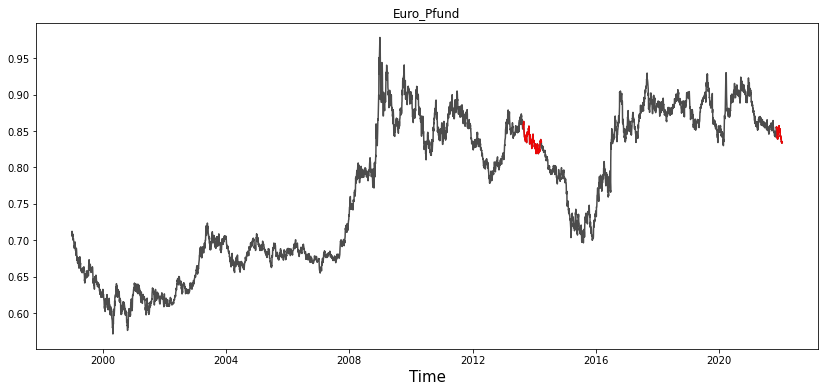

In [41]:
mkal(ts)

Column Euro_Pfund
Grammar motif 1 = aabcdd abbccd aacccd aabcdd abbcdd
Column Euro_Pfund
Grammar motif 2 = babcdd aabcdd aabddc
Column Euro_Pfund
Grammar motif 3 = ddcaba ddbbba dcbcaa
0:00:02.940857


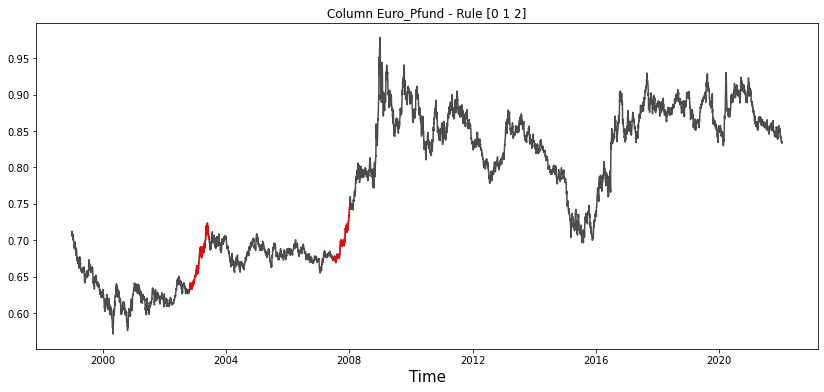

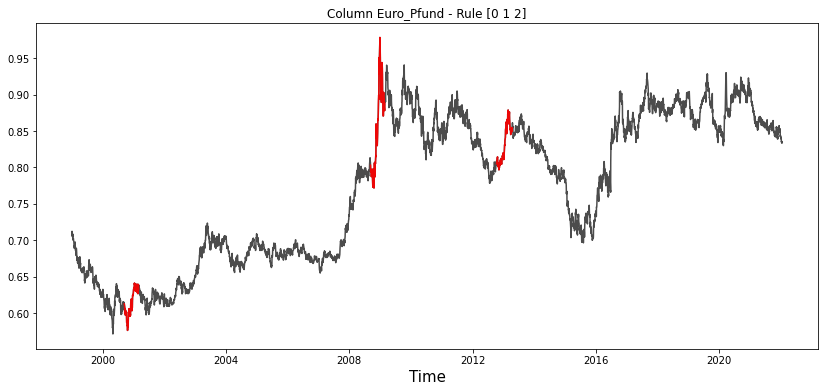

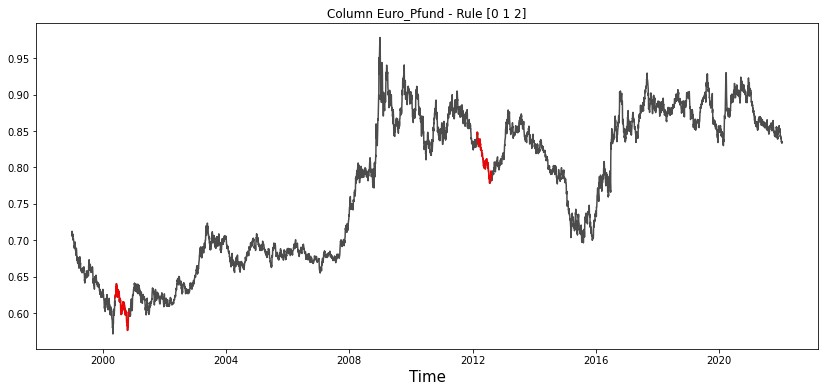

In [25]:
Grammarintroduction(ts)

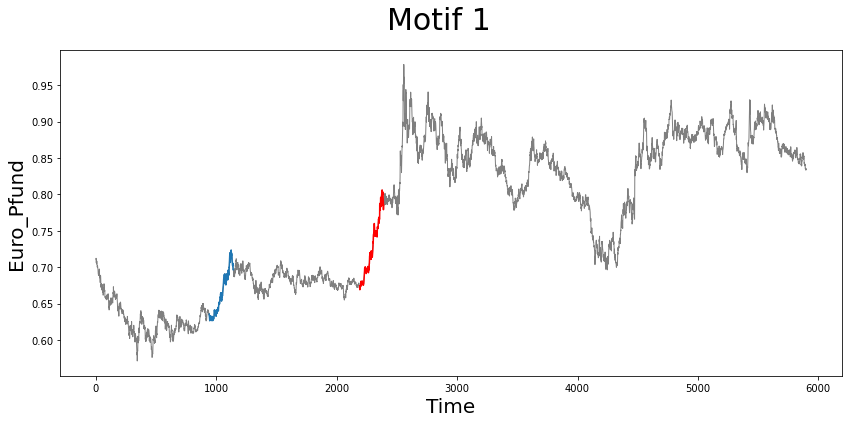

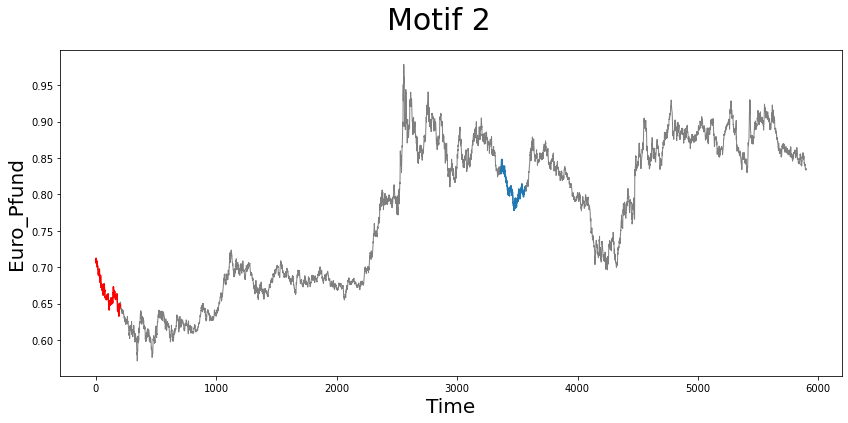

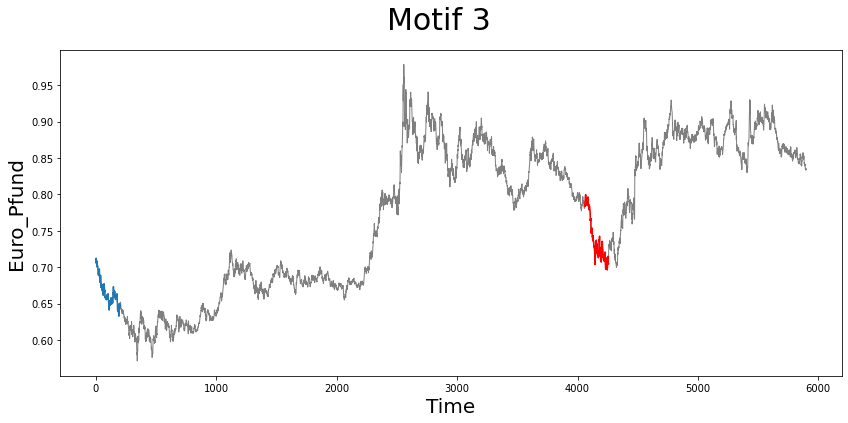

0:00:00.443502


In [17]:
Stump(ts)

0:00:01.335355


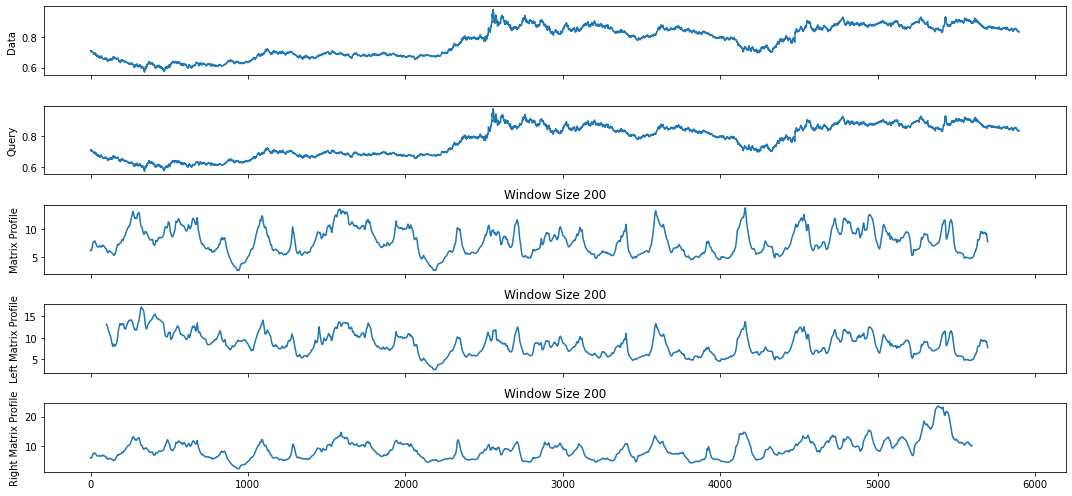

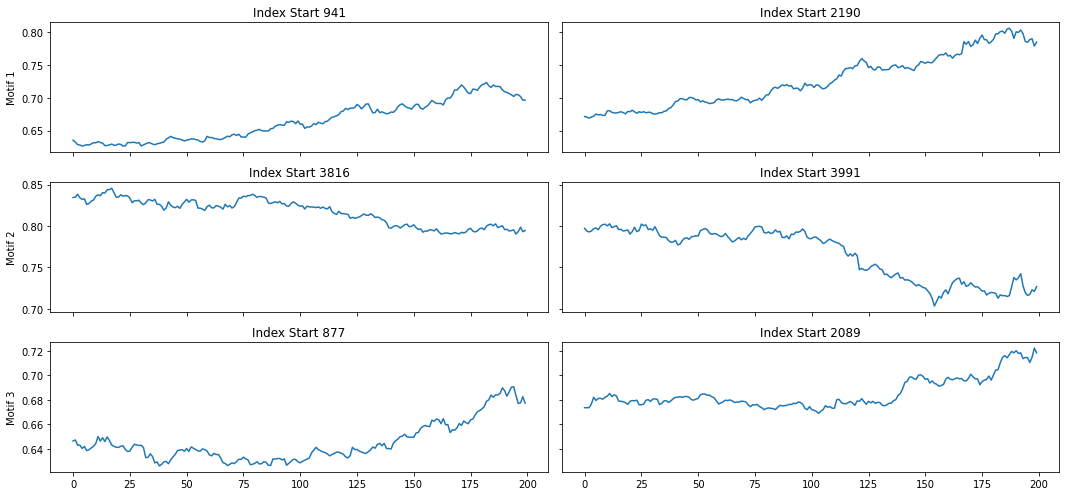

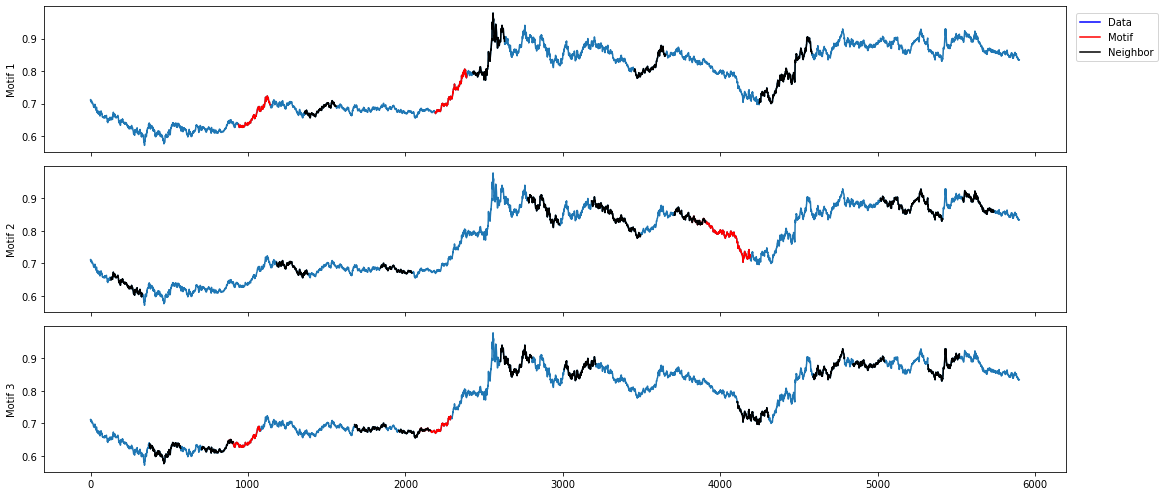

In [18]:
Stomp(ts)

0:00:00.533150


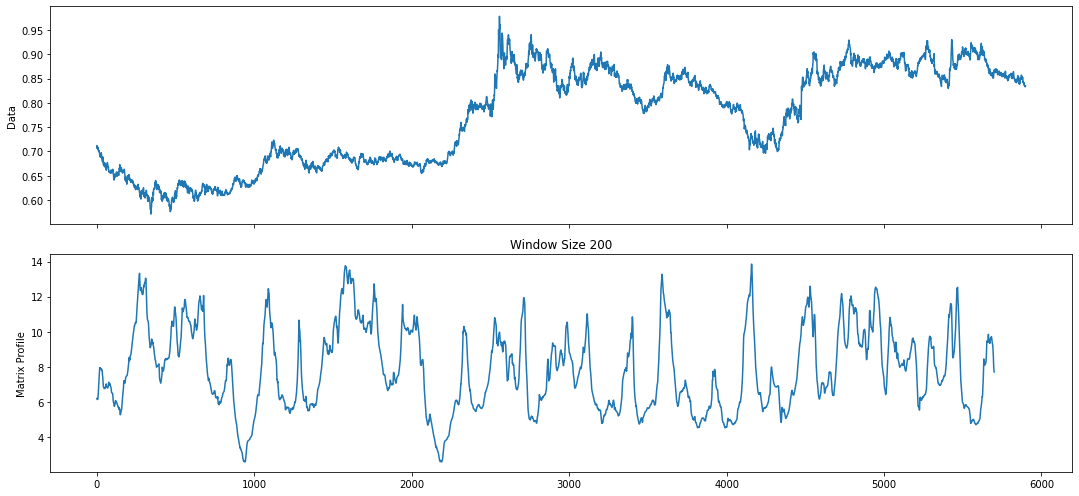

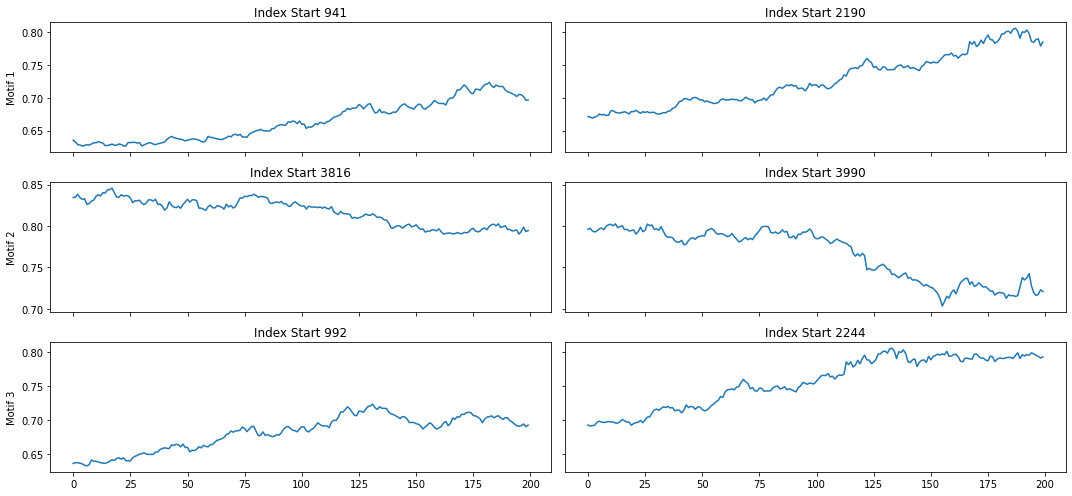

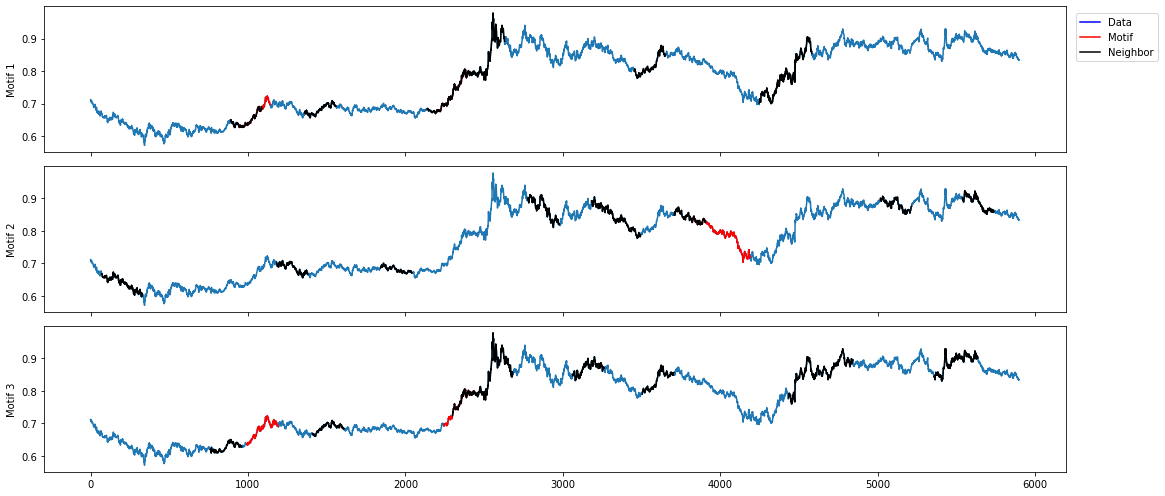

In [22]:
Scrimp_2plus(ts)

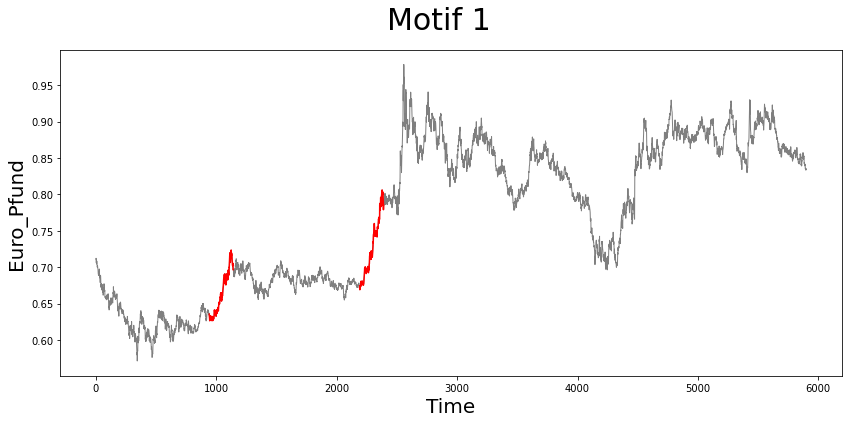

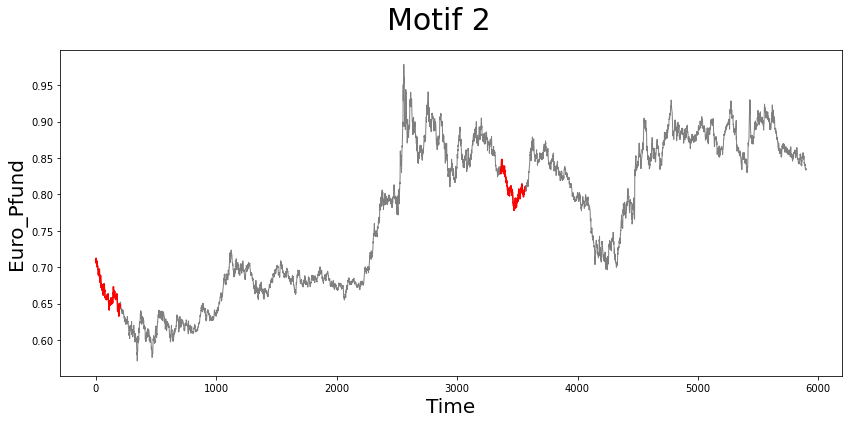

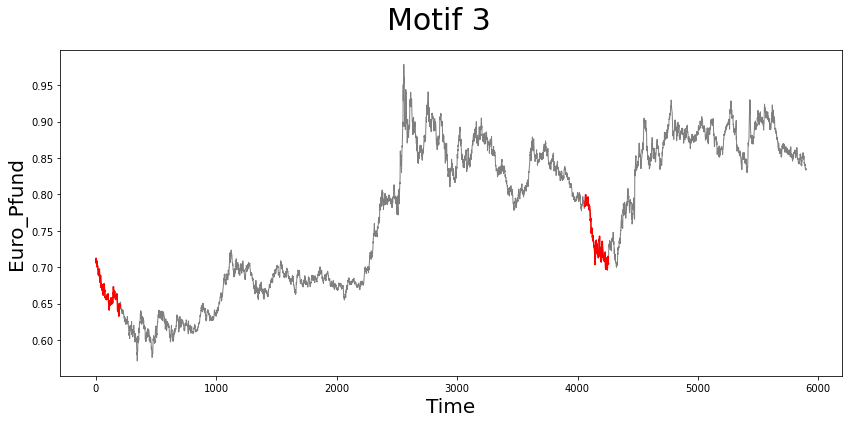

0:00:01.504919


In [23]:
gpu_Stump(ts)